# Import packages

In [154]:
import numpy as np 
import pandas as pd
from math import isnan 

#setting up the data and cleaning 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

#model to use 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC

# measure the score of the model 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [165]:
#Import the data 
cust_churn = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Dont inlcude the customer ID as may cause leakage later on down the line
cust_churn = cust_churn.drop('customerID',axis = 1)

# Turn the total charges into a numeric data type with nan for the unreadable columns 
cust_churn['TotalCharges'] = pd.to_numeric(cust_churn['TotalCharges'],errors = 'coerce')

#remove the nan values from the dataset 
#drop na results so both columns the same lentgh 
cut_churn = cust_churn[['TotalCharges','tenure']].dropna()

#Turn the y values into a binary output
#Turn churn into an integer binary value
cust_churn.loc[cust_churn['Churn'] == 'No', 'Churn'] = 0
cust_churn.loc[cust_churn['Churn'] == 'Yes', 'Churn'] = 1

#Turns churn into a numeric data type so the model can use it 
cust_churn['Churn'] = pd.to_numeric(cust_churn['Churn'])

# Find y = mx + c and use it to find the missing values with highly correlated columns
#Only a small ammount of missing values so minimal worry about colinearity 
mb = np.polyfit(cust_churn['tenure'], cust_churn['TotalCharges'], 1)

for i in range(len(cust_churn)):
    if pd.isna(cust_churn.loc[i, 'TotalCharges']):
        cust_churn.loc[i, 'TotalCharges'] = mb[0] * cust_churn.loc[i, 'tenure'] + mb[1]


In [60]:
cust_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [113]:
#expolre object data ad check one hot encoding wont produce to many columns and if there is any NA values 
#total charges will need to be changed to a numeric data type 
cust_churn['PaperlessBilling'].drop_duplicates()

0    Yes
1     No
Name: PaperlessBilling, dtype: object

Quite a few services have no internet service in column so this won't be needed. We can just use the internet service instead to one hot encode this 

In [77]:
# Check to see if we have any collinearity and if any factors should be dropped 
cust_churn[(cust_churn.select_dtypes(include = ['float64','int64']).columns)].corr()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
SeniorCitizen,1.000000,0.016567,0.220173,0.102411,0.150889
tenure,0.016567,1.000000,0.247900,0.825880,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.651065,0.193356
TotalCharges,0.102411,0.825880,0.651065,1.000000,-0.199484
Churn,0.150889,-0.352229,0.193356,-0.199484,1.000000


In [63]:
############################# bulding the model pipeline #######################

In [96]:
cust_churn['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [95]:
# Replace all columns that have no internet service or no phone sercive is, we can then replace these with No for the one hot encoder as these columns are not needed
# If they dont have phone or internet service they will obviously not have the add on package  
for column in cust_churn.columns:
    if cust_churn[column].dtype == 'object':  
        cust_churn[column] = cust_churn[column].replace({'No phone service': 'No', 'No internet service': 'No'})

In [139]:
def OHE_cust_churn_fun(df):
    # One hot encode all object variables unless there are 2 columns, then do it as one
    object_cols = df.select_dtypes(include=['object']).columns
    encoder = OneHotEncoder(drop=None, sparse_output=False)
    encoded_cols = pd.DataFrame(encoder.fit_transform(df[object_cols]))
    encoded_cols.columns = encoder.get_feature_names_out(object_cols)

    # Drop columns that have _No in the title as it's just the opposite value of yes
    for column in list(encoded_cols.columns):
        if 'No' in column.split('_'):
            encoded_cols.drop(column, axis=1, inplace=True)

    # Drop columns from the original dataframe and append OHE on
    df.drop(df.select_dtypes(include=['object']).columns, axis=1, inplace=True)
    df = pd.concat([df, encoded_cols], axis=1)

    return df

cust_churn_ohe = OHE_cust_churn_fun(cust_churn)

In [146]:
#X and y created from data sets 
#The customer id if 
X = cust_churn_ohe.drop('Churn',axis = 1)
y = cust_churn_ohe['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100)

In [163]:
cust_churn.isnull().sum()

SeniorCitizen      0
tenure             0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

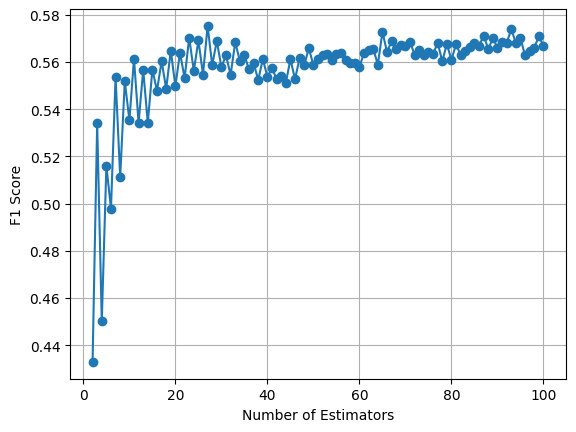

In [155]:
# find the number of branches needed to minimize the error 
# no emphasise on high precision or recall so f1 score used to get both 
#70 appears to be the best 
estimators = list(range(2, 101))
f1_scores = []

# Iterate over the range of estimators
for i in estimators:
    RFC = RandomForestClassifier(random_state=0, n_estimators=i)
    RFC.fit(X_train, y_train)
    y_pred_RFC = RFC.predict(X_test)
    score = f1_score(y_test, y_pred_RFC)
    f1_scores.append(score)
    #print(f"n_estimators: {i}, f1_score: {score}")

plt.plot(estimators, f1_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [158]:
#C = 1 has the highest f1 score appears to be the best the same method 
Log = LogisticRegression(random_state = 0)
Log.fit(X_train,y_train)
y_pred_log = Log.predict(X_test)
print(f1_score(y_test,y_pred_log))

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [438]:
#all degrees of polynomial function produced the same result so 1 was used. Most likely due to the small size of the data set 
#No change  in ovo or ovr
for i in ('ovr','ovo'):
    SVC_mod = SVC(random_state = 0,decision_function_shape = i)
    SVC_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', SVC_mod)])
    SVC_pipeline.fit(X_train,y_train)
    y_pred_SVC = SVC_pipeline.predict(X_test)
    print(f1_score(y_test,y_pred_SVC))

0.5611192930780559
0.5611192930780559


In [568]:
import random 
#Check if score is better than random guessing y_test
for i in range(0,5):
    rnd_set = []
    for i in range(0,len(y_test)):
        if random.uniform(0, 1) < (y_test.sum()/len(y_test)):
            rnd_set.append(1)
        else:
            rnd_set.append(0)

    print(f1_score(rnd_set,y_pred))

0.24975984630163303
0.24112149532710278
0.23282442748091603
0.23716153127917833
0.23062730627306272


In [414]:
#value is better than random guessing for the models that are used
#higher precision preferred if future incentive is expensive for customer but vice versa for recall
#Logistic regression produced the best result overall 
#cross validation not used due to the small sample size 

In [569]:
#Find the atributions of the model that cause the greatest change when not included 
atb_values = {}

for i in X.columns:
    tot = 0
    X_train_drop_cols = X_train.columns.tolist()
    X_train_drop_cols.remove(i)
    
    categorical_cols = X[X_train_drop_cols].select_dtypes(include = 'object').columns
    
    ohe_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
    transformers=[('cat', ohe_pipeline, categorical_cols)
    ])
    
    Log = LogisticRegression(random_state = 0)
    Log_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                         ('model', Log)])
    
    #print(X_train_drop_cols)
    #print(X_test[X_train_drop_cols])
    Log_pipeline.fit(X_train[X_train_drop_cols],y_train)
    y_pred = Log_pipeline.predict(X_test[X_train_drop_cols])
    tot += f1_score(y_test,y_pred)
    atb_values[i] = tot
    
    

<BarContainer object of 19 artists>

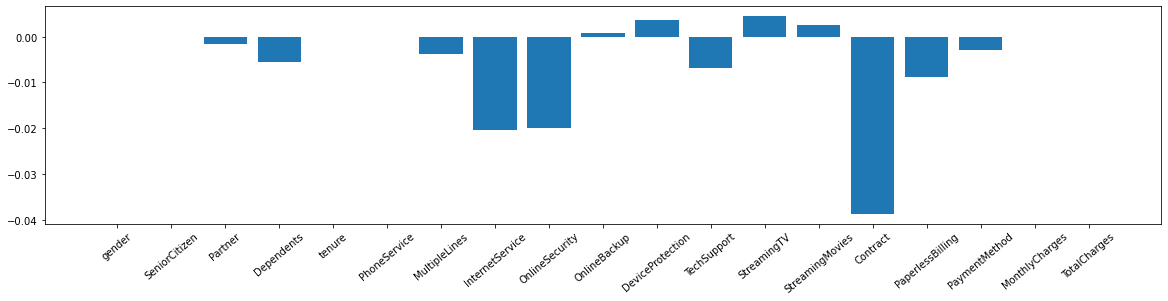

In [570]:
#Greatest drop from contract not being included showing it was one of the greatest
#determining factors in finding the probability of churn 
import matplotlib.pyplot as plt
keys = atb_values.keys()
values = list(atb_values.values())
for i in range(0,len(values)):
    values[i] = values[i] - f1_score(y_test,y_pred_log) # take off the f1 score of previous to see how much each one drops 
plt.figure(figsize=(20,4))
plt.xticks(rotation=40)
plt.bar(keys, values)